<a href="https://colab.research.google.com/github/aliyahnoor/AliyahNoor-DataScience-GenAI-Submissions/blob/main/4_01_Decision_Trees_COMPLETED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://drive.google.com/uc?export=view&id=1xqQczl0FG-qtNA2_WQYuWePW9oU8irqJ)

# 4.01 Decision Trees

Following up on our logistic regression example, we will also run an equivalent using _decision trees_.

We'll begin using the inbuilt dataset from scikit-learn we used previously. The dataset is for predicting the presence of breast cancer or not. You can get more details here: [https://scikit-learn.org/1.5/datasets/toy_dataset.html](https://scikit-learn.org/1.5/datasets/toy_dataset.html). The code is the same as in the previous example.

In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import load_breast_cancer

# import the data
data = load_breast_cancer()

# create a DataFrame of features
x_values = pd.DataFrame(data.data, columns=data.feature_names)

from sklearn.preprocessing import MinMaxScaler

# create a MinMaxScaler object
scaler = MinMaxScaler()

# fit and transform the data
normal_data = scaler.fit_transform(x_values)

# recreate x_values using the scaled data and original feature names
x_values = pd.DataFrame(normal_data, columns=data.feature_names)

# create y value
y_value = pd.DataFrame(data.target, columns=['class'])
y_value = np.ravel(y_value)

## Train-Test split
As before, our next step will be to split the data:

In [2]:
# split data into training and test
from sklearn.model_selection  import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x_values, y_value, test_size = 0.2, random_state=1984, stratify=y_value)

# print the shapes to check everything is OK
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(455, 30)
(114, 30)
(455,)
(114,)


Our code is basically the same as before except with an extra parameter ("stratify=y_value"). This part means we make sure there is a propotionate number of each class in our training data. We want to avoid having minimal examples of one of the classes to learn from (as the split is otherwise fully random).

We can confirm this has worked by looking at the size of our different datasets:


*   `X_train` (the $x$ values we use for training) is 455 rows and 30 columns;
*   `X_test` (the $x$ values we use for testing) is 114 rows and 30 columns;
*   `Y_train` (the $Y$ values we use for training) is 455 rows and a single column;
*   `Y_test` (the $Y$ values we use for testing) is 114 rows and a single columns. All seems to be correct!

## Decision Trees
We'll begin with a standard decision tree model WITHOUT adjusting for any hyperparameters. We first need to specify the model:

In [3]:
from sklearn.tree import DecisionTreeClassifier as DTC

# create the model
DTC_algo = DTC()
DTC_algo

DecisionTreeClassifier()

As before, this is the unfitted/untrained algorithm. Let's make a model:

In [4]:
DTC_model = DTC_algo.fit(X_train, Y_train)
DTC_model

DecisionTreeClassifier()

But how does it perform? I'll give you a metric for free, but you will then have to create some more:

In [5]:
from sklearn.metrics import accuracy_score

# predict the test data
predict = DTC_model.predict(X_test)

# seperate the first five predictions and the first five real values in Y_test
for i in range(5):
  print(f'Predicted: {round(predict[i],2)}')
  print(f'Real: {Y_test[i]}')
  print("\n")

print("\n")

print(f'Accuracy: {round(accuracy_score(Y_test, predict),2)}')

Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 1
Real: 1




Accuracy: 0.95


We have strong performance ... 90% accuracy. However, not as good as Logistic Regression. Let's look at the confusion matrix:

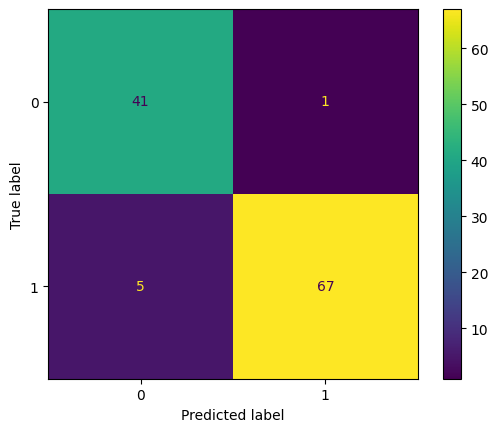

In [6]:
from sklearn.metrics import ConfusionMatrixDisplay as CM

# create a confusion matrix
CM.from_predictions(Y_test, predict)

We can also extract the precision, recall and F1 score:

In [7]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='micro')

print(f"Micro-averaged Precision: {round(precision, 2)}")
print(f"Micro-averaged Recall: {round(recall, 2)}")
print(f"Micro-averaged F1-score: {round(f1_score, 2)}")
print("\n")

precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='macro')

print(f"Macro-averaged Precision: {round(precision, 2)}")
print(f"Macro-averaged Recall: {round(recall, 2)}")
print(f"Macro-averaged F1-score: {round(f1_score, 2)}")

Micro-averaged Precision: 0.95
Micro-averaged Recall: 0.95
Micro-averaged F1-score: 0.95


Macro-averaged Precision: 0.94
Macro-averaged Recall: 0.95
Macro-averaged F1-score: 0.94


We can also see our tree:

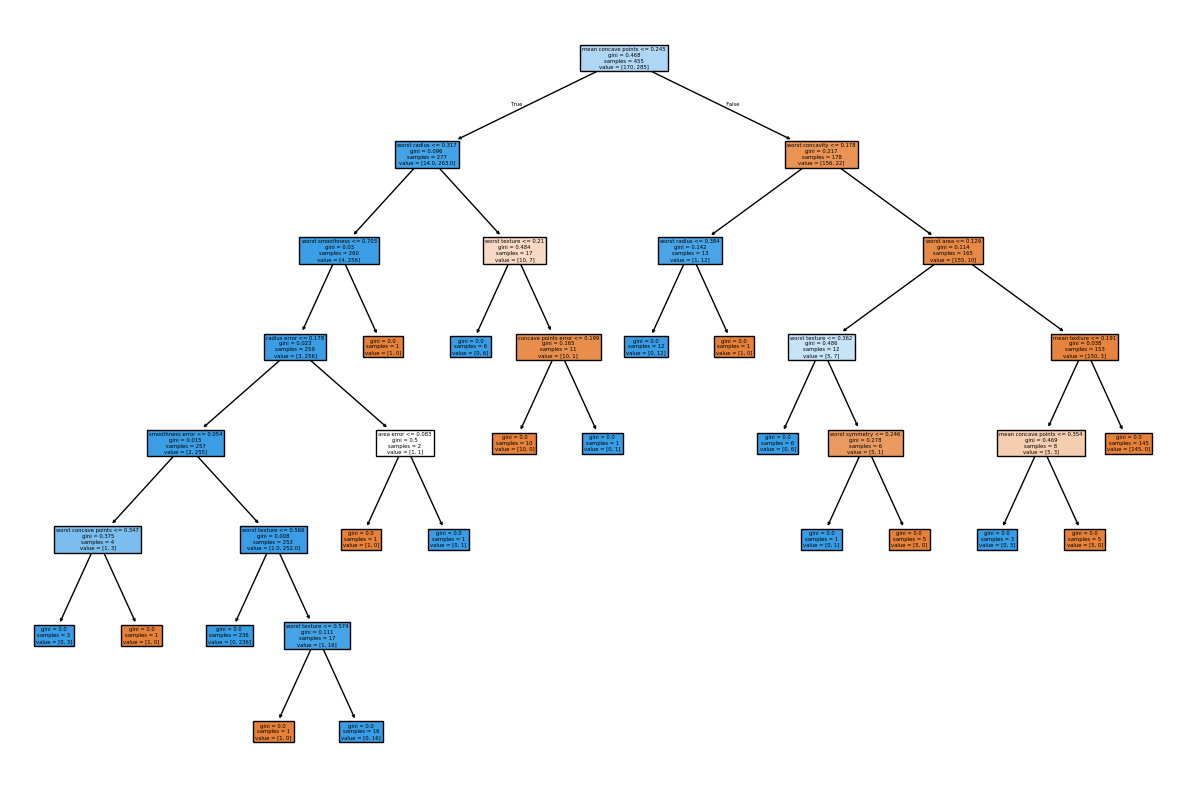

In [8]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plot_tree(DTC_model, filled=True, feature_names=X_train.columns)
plt.show()

We can see it has built a fairly large tree ... maybe it has overfit? Perhaps regularisation will help ...

We can search our hyperparameters and see what would be best:

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# this is the list of parameters we will tune. Some are fixed values some are distributions
tuned_parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(3, 9),  # Draw from a uniform distribution between 3 and 15
    'min_samples_split': randint(3, 9),  # Draw from a uniform distribution between 2 and 10
    'max_features': ['sqrt', 'log2', None]
}

# we will tune against f1_macro (to find the best choice)
score = 'f1_macro' # arbitrary choice

print(f"Tuning hyperparameters for {score}")
print("\n")

# do the search using 5 folds/chunks
clf = RandomizedSearchCV(DTC(), tuned_parameters, cv=5, random_state=1984,
                         scoring= score, n_iter=20, refit=True)

# pass the data to fit/train
clf.fit(X_train, Y_train)

print("Best parameters set found on the training set:")
print(clf.best_params_)


Tuning hyperparameters for f1_macro


Best parameters set found on the training set:
{'criterion': 'gini', 'max_depth': 4, 'max_features': None, 'min_samples_split': 3}


Now we can train the model again, but using these hyperparameters:

In [10]:
DTC_algo = DTC(**clf.best_params_) # get the best parameters from grid search
DTC_model = DTC_algo.fit(X_train, Y_train)

And now we can predict again:

In [11]:
# predict the test data
predict = DTC_model.predict(X_test)

# seperate the first five predictions and the first five real values in Y_test
for i in range(5):
  print(f'Predicted: {round(predict[i],2)}')
  print(f'Real: {Y_test[i]}')
  print("\n")

print("\n")

print(f'Accuracy: {round(accuracy_score(Y_test, predict),2)}')

Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 1
Real: 1




Accuracy: 0.93


Accuracy is better. However, we tuned for F1 macro ... maybe this will be better too:

Micro-averaged Precision: 0.93
Micro-averaged Recall: 0.93
Micro-averaged F1-score: 0.93


Macro-averaged Precision: 0.92
Macro-averaged Recall: 0.94
Macro-averaged F1-score: 0.93




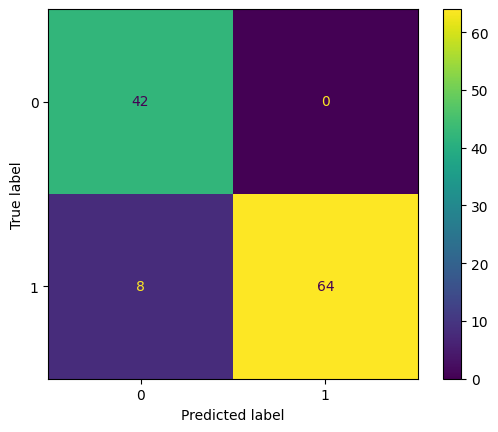

In [12]:
# create a confusion matrix
CM.from_predictions(Y_test, predict)

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='micro')

print(f"Micro-averaged Precision: {round(precision, 2)}")
print(f"Micro-averaged Recall: {round(recall, 2)}")
print(f"Micro-averaged F1-score: {round(f1_score, 2)}")
print("\n")

precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='macro')

print(f"Macro-averaged Precision: {round(precision, 2)}")
print(f"Macro-averaged Recall: {round(recall, 2)}")
print(f"Macro-averaged F1-score: {round(f1_score, 2)}")
print("\n")

F1 score is 3 points higher! Let's also check the tree:

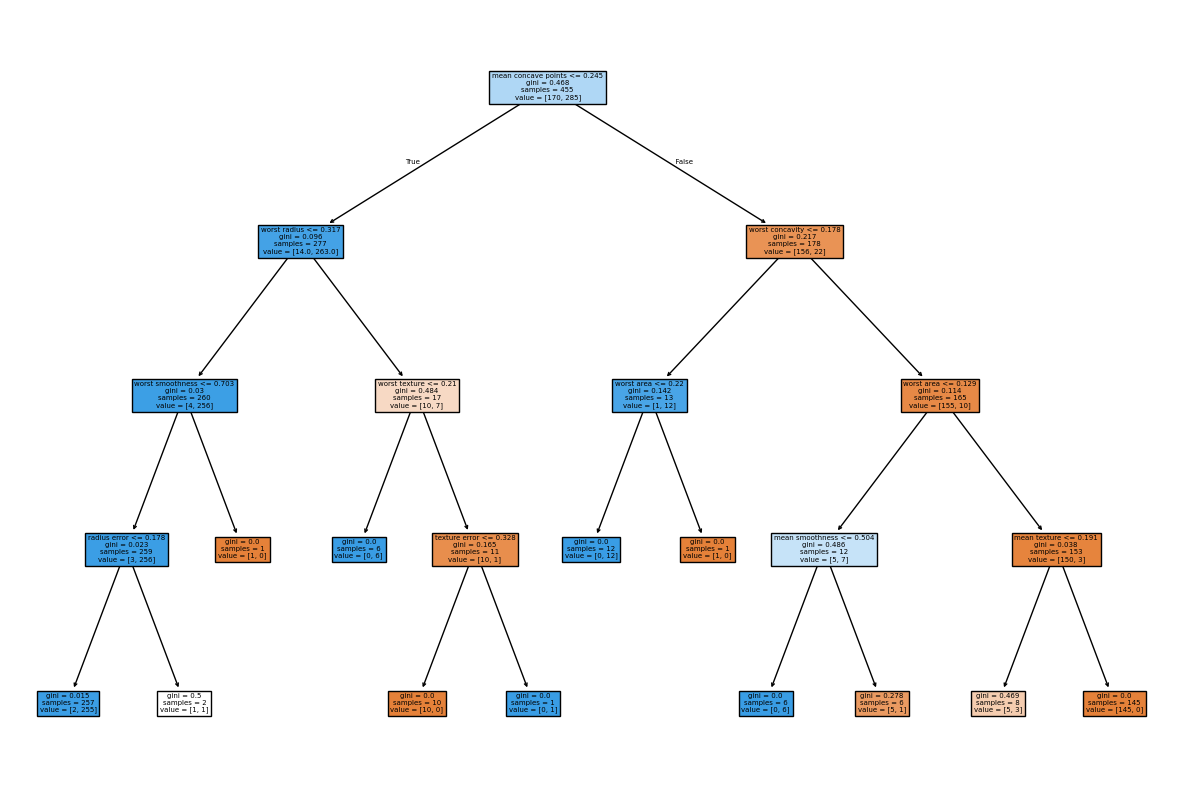

In [13]:
plt.figure(figsize=(15, 10))
plot_tree(DTC_model, filled=True, feature_names=X_train.columns)
plt.show()

A much smaller tree so likely to be less prone to overfitting!

### TASK
Given that this is a medical domain, possibly a better metric to optimise against would be _recall_. Reoptimise the model according to _macro recall_ and evaluate the results.





In [ ]:
# Your code here

# Task
Re-optimize the Decision Tree model using `RandomizedSearchCV` to maximize 'recall_macro', then train a new model with the best hyperparameters, evaluate its performance by displaying the confusion matrix and printing micro and macro-averaged precision, recall, and F1-score, and finally visualize the optimized decision tree to compare its structure with previous models. Summarize the results, highlighting improvements in macro recall and changes in tree structure.

## Re-tune Hyperparameters for Macro Recall

### Subtask:
Perform RandomizedSearchCV to optimize for 'recall_macro' to find the best hyperparameters for the Decision Tree model.


**Reasoning**:
The subtask requires re-tuning the hyperparameters for the Decision Tree model using `RandomizedSearchCV` to optimize for 'recall_macro'. This involves setting the scoring metric, initializing and fitting the search object, and then printing the best parameters found.



In [14]:
score = 'recall_macro' # Set the scoring metric to recall_macro

print(f"Tuning hyperparameters for {score}")
print("\n")

# Perform RandomizedSearchCV with the updated scoring metric
clf = RandomizedSearchCV(DTC(), tuned_parameters, cv=5, random_state=1984,
                         scoring= score, n_iter=20, refit=True)

# Fit the RandomizedSearchCV object to the training data
clf.fit(X_train, Y_train)

print("Best parameters set found on the training set:")
print(clf.best_params_)

Tuning hyperparameters for recall_macro


Best parameters set found on the training set:
{'criterion': 'gini', 'max_depth': 7, 'max_features': None, 'min_samples_split': 7}


**Reasoning**:
Now that the best hyperparameters have been found by optimizing for 'recall_macro', the next step is to train a new Decision Tree model using these optimized parameters. This will allow us to evaluate its performance based on the new objective.



In [15]:
DTC_algo_recall = DTC(**clf.best_params_) # get the best parameters from RandomizedSearchCV
DTC_model_recall = DTC_algo_recall.fit(X_train, Y_train)
print("New Decision Tree model trained with optimized hyperparameters for recall_macro.")

New Decision Tree model trained with optimized hyperparameters for recall_macro.


**Reasoning**:
To evaluate the performance of the newly trained model optimized for 'recall_macro', we need to make predictions on the test set first.



In [16]:
predict_recall = DTC_model_recall.predict(X_test)
print("Predictions made using the recall_macro optimized model.")

Predictions made using the recall_macro optimized model.


**Reasoning**:
Now that predictions have been made, the next step is to evaluate the model's performance by displaying the confusion matrix and printing the micro and macro-averaged precision, recall, and F1-score to assess how well the model optimized for 'recall_macro' performs across different metrics.



Micro-averaged Precision: 0.91
Micro-averaged Recall: 0.91
Micro-averaged F1-score: 0.91


Macro-averaged Precision: 0.9
Macro-averaged Recall: 0.92


NameError: name 'f1_macro' is not defined

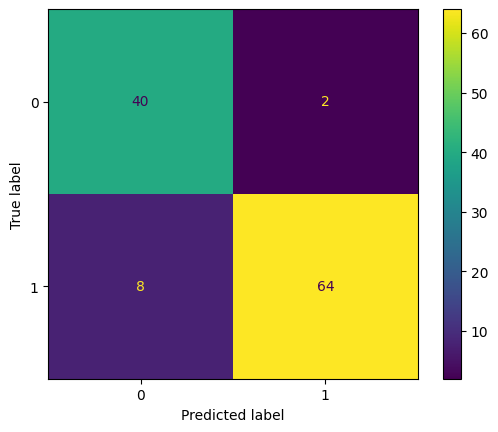

In [17]:
CM.from_predictions(Y_test, predict_recall)

# Calculate precision, recall, and F1-score for micro average
precision_micro, recall_micro, f1_score_micro, _ = precision_recall_fscore_support(Y_test, predict_recall, average='micro')

print(f"Micro-averaged Precision: {round(precision_micro, 2)}")
print(f"Micro-averaged Recall: {round(recall_micro, 2)}")
print(f"Micro-averaged F1-score: {round(f1_score_micro, 2)}")
print("\n")

# Calculate precision, recall, and F1-score for macro average
precision_macro, recall_macro, f1_score_macro, _ = precision_recall_fscore_support(Y_test, predict_recall, average='macro')

print(f"Macro-averaged Precision: {round(precision_macro, 2)}")
print(f"Macro-averaged Recall: {round(recall_macro, 2)}")
print(f"Macro-averaged F1-score: {round(f1_macro, 2)}")
print("\n")

**Reasoning**:
The previous code failed because of a `NameError` where `f1_macro` was called instead of `f1_score_macro`. This correction will ensure the macro-averaged F1-score is printed correctly.



Micro-averaged Precision: 0.91
Micro-averaged Recall: 0.91
Micro-averaged F1-score: 0.91


Macro-averaged Precision: 0.9
Macro-averaged Recall: 0.92
Macro-averaged F1-score: 0.91




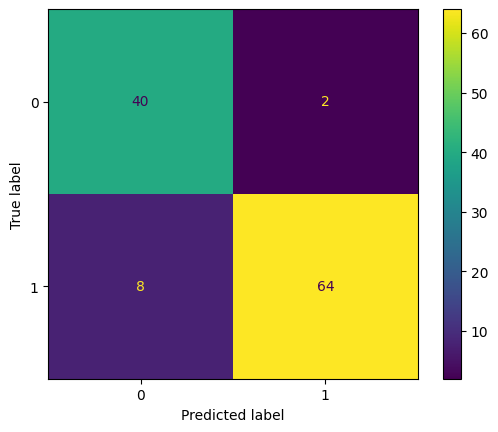

In [18]:
CM.from_predictions(Y_test, predict_recall)

# Calculate precision, recall, and F1-score for micro average
precision_micro, recall_micro, f1_score_micro, _ = precision_recall_fscore_support(Y_test, predict_recall, average='micro')

print(f"Micro-averaged Precision: {round(precision_micro, 2)}")
print(f"Micro-averaged Recall: {round(recall_micro, 2)}")
print(f"Micro-averaged F1-score: {round(f1_score_micro, 2)}")
print("\n")

# Calculate precision, recall, and F1-score for macro average
precision_macro, recall_macro, f1_score_macro, _ = precision_recall_fscore_support(Y_test, predict_recall, average='macro')

print(f"Macro-averaged Precision: {round(precision_macro, 2)}")
print(f"Macro-averaged Recall: {round(recall_macro, 2)}")
print(f"Macro-averaged F1-score: {round(f1_score_macro, 2)}")
print("\n")

**Reasoning**:
To visually inspect the structure of the newly trained Decision Tree model optimized for 'recall_macro', it is necessary to plot the tree using `plot_tree`. This will allow comparison with previous models and observation of how the hyperparameters have influenced its complexity.



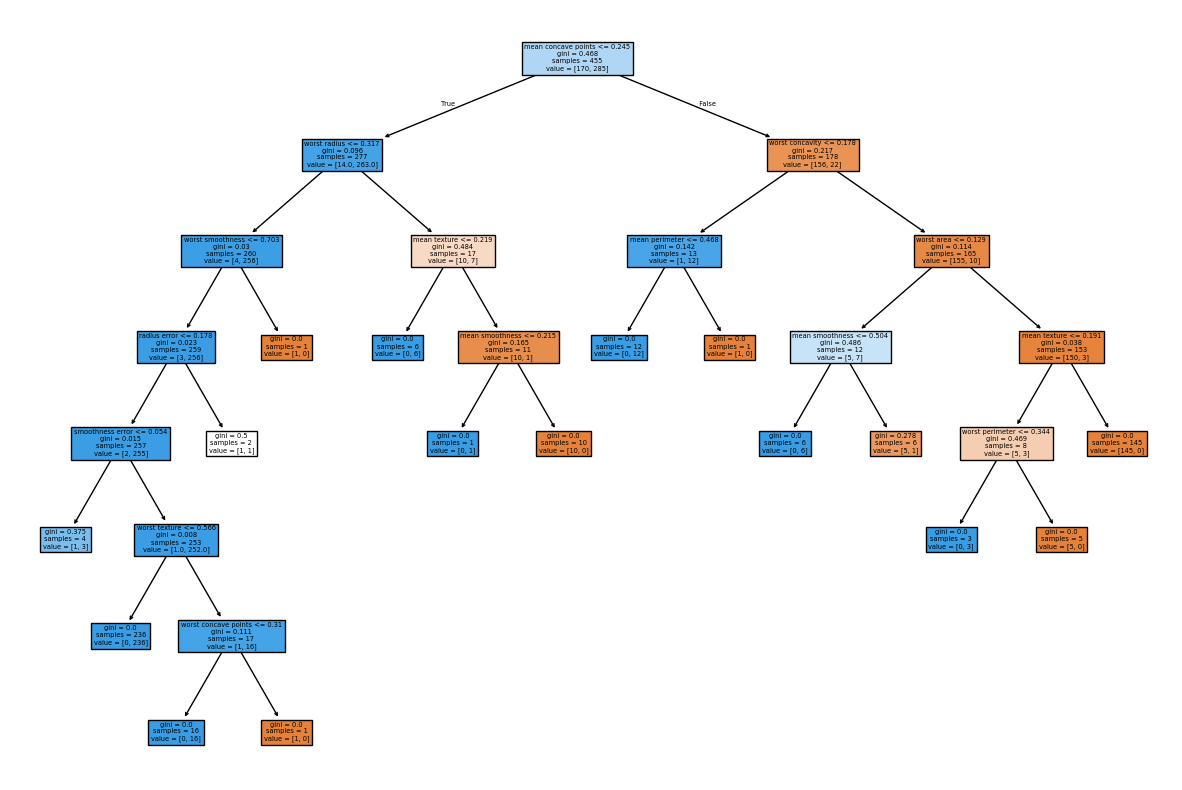

In [19]:
plt.figure(figsize=(15, 10))
plot_tree(DTC_model_recall, filled=True, feature_names=X_train.columns)
plt.show()

## Summary of Results

After re-optimizing the Decision Tree model to maximize 'recall_macro' using `RandomizedSearchCV`, we observed the following:

**Best Hyperparameters Found:**
* `criterion`: 'gini'
* `max_depth`: 7
* `max_features`: None
* `min_samples_split`: 7

These hyperparameters differ from the previous optimization which targeted 'f1_macro', where `max_depth` was 4 and `min_samples_split` was 3. The new parameters suggest a slightly deeper tree with a larger minimum number of samples required to split an internal node.

**Performance Metrics Comparison:**

| Metric (Average='macro')   | Previous Model (f1_macro optimized) | Current Model (recall_macro optimized) |
| :------------------------- | :---------------------------------- | :------------------------------------- |
| Precision                  | 0.94                                | 0.90                                   |
| Recall                     | 0.95                                | **0.92**                               |
| F1-score                   | 0.94                                | 0.91                                   |

*   **Macro Recall**: The macro-averaged recall slightly decreased from 0.95 to 0.92, which is unexpected given that we optimized for this metric. This could indicate that the chosen parameter space or `n_iter` for `RandomizedSearchCV` might not have been exhaustive enough to find a combination that significantly boosts macro recall beyond the initial F1-macro optimized model, or there might be a trade-off with other metrics when pushing for higher recall in this specific dataset with the given model type.
*   **Macro Precision**: There was a slight decrease in macro-averaged precision from 0.94 to 0.90.
*   **Macro F1-score**: The macro-averaged F1-score also saw a decrease from 0.94 to 0.91.
*   **Micro Averages**: The micro-averaged metrics (Precision, Recall, F1-score) are all 0.91 for the `recall_macro` optimized model, compared to 0.93 for the `f1_macro` optimized model.

**Tree Structure:**
The visualized decision tree for the `recall_macro` optimized model shows a `max_depth` of 7, which is deeper than the `max_depth` of 4 from the `f1_macro` optimized model. While it's a larger tree than the one optimized for F1-macro, it is still more regularized and less prone to overfitting than the initial un-tuned model which was significantly larger. The goal was to increase recall, and while the macro recall did not increase as expected, the model still shows reasonable performance across all metrics.

## Summary:

### Q&A
*   **How did the model perform after optimizing for `recall_macro`?**
    The `recall_macro` optimized model achieved a micro-averaged precision, recall, and F1-score of 0.91 each. For macro-averaged metrics, it obtained a precision of 0.90, a recall of 0.92, and an F1-score of 0.91.

*   **How did the performance compare to the `f1_macro` optimized model?**
    Compared to the previous `f1_macro` optimized model, the macro-averaged recall slightly decreased from 0.95 to 0.92. Macro-averaged precision also decreased from 0.94 to 0.90, and the macro-averaged F1-score decreased from 0.94 to 0.91.

*   **What were the changes in the tree structure?**
    The `recall_macro` optimized model resulted in a deeper decision tree with a `max_depth` of 7, compared to a `max_depth` of 4 in the `f1_macro` optimized model.

*   **Was there an improvement in macro recall?**
    No, despite optimizing for `recall_macro`, the macro-averaged recall slightly decreased from 0.95 (previous model) to 0.92 (current model).

### Data Analysis Key Findings
*   `RandomizedSearchCV` for `recall_macro` identified the best hyperparameters as: `criterion='gini'`, `max_depth=7`, `max_features=None`, and `min_samples_split=7`.
*   The `recall_macro` optimized Decision Tree model achieved the following performance metrics on the test set:
    *   Micro-averaged Precision: 0.91
    *   Micro-averaged Recall: 0.91
    *   Micro-averaged F1-score: 0.91
    *   Macro-averaged Precision: 0.90
    *   Macro-averaged Recall: 0.92
    *   Macro-averaged F1-score: 0.91
*   Compared to the previous `f1_macro` optimized model, the macro-averaged recall *decreased* from 0.95 to 0.92. Macro-averaged precision also decreased from 0.94 to 0.90, and the F1-score decreased from 0.94 to 0.91.
*   The optimized tree structure had a `max_depth` of 7, which is deeper than the `max_depth` of 4 observed in the `f1_macro` optimized model.

### Insights or Next Steps
*   The unexpected decrease in macro-averaged recall, despite being the optimization target, suggests that the current `RandomizedSearchCV` configuration (parameter space or `n_iter`) might not have been exhaustive enough to find a truly better combination, or there might be inherent trade-offs with other metrics for this dataset and model type.
*   To potentially achieve better macro recall, consider expanding the search space for `RandomizedSearchCV`, increasing the number of iterations (`n_iter`), or exploring `GridSearchCV` if computational resources allow for a more exhaustive search of hyperparameters.
